In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import regex as re
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer  
import pickle

import spacy
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/4000-Stories-with-sentiment-analysis.xlsx')

In [ ]:
df.head(2)

,Unnamed: 0,url,length,title,text_no,author,story,valence,arousal,dominance,text_id,processed_text,word_count,sentence_length,string_length,unique_words,lexical_diversity,concrete,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0,https://americanliterature.com/author/eleanor-...,15044,"Peace on Earth, Good-Will to Dogs",0,Eleanor Hallowell Abbott,"PART I\n\nIf you don't like Christmas stories,...",0.592896,0.397839,0.569567,0_eleanor-hallowell-abbott-peace-on-earth-good...,part i if not like christmas story not read an...,9033,11.964912,5.968875,2548,0.282077,0.555175,4.861874,4.319759,0.163068,8.358159,5.208221,8.372235,-7.121128,1.512226,-7.933094,1.295583,-7.097304,2.419966,3.327276,2.917077,-4.512812,5.374939,5.040714,5.009961,-9.276822,-4.718969,-1.634965,-4.669248,...,-2.006219,4.126678,4.434412,7.204116,3.333428,-0.117424,4.303011,0.130948,3.675465,-2.348651,6.085864,-5.057386,2.257509,-11.803610,4.749285,0.983522,6.734220,-5.208762,5.842612,-2.317917,-4.925443,4.718173,1.468855,-1.377871,-7.700944,1.952728,-13.489065,12.533296,-3.321778,-6.803755,3.793141,3.837345,3.778354,-0.815515,-0.720440,-10.738245,-8.765683,0.875089,-10.176691,1.736791
1,1,https://americanliterature.com/author/eleanor-...,10874,The Indiscreet Letter,1,Eleanor Hallowell Abbott,The Railroad Journey was very long and slow. T...,0.593563,0.381156,0.574662,1_eleanor-hallowell-abbott-the-indiscreet-letter,the railroad journey long slow the traveling s...,6080,24.357303,5.765477,1876,0.308553,0.533698,3.134114,5.642848,-7.120562,3.248666,2.730297,0.114951,-3.648374,3.018176,5.326436,-1.634649,2.018243,1.535305,-1.275911,2.114145,2.958743,-8.385591,-2.965207,0.902382,-4.429614,-5.579678,0.973481,4.390507,...,-1.466449,0.844802,5.161949,4.118372,2.676588,0.251970,-4.197124,0.293951,1.258946,-4.257861,4.711821,-1.146002,0.939830,2.208132,1.370910,-2.455004,-2.719983,6.407780,2.046252,0.799790,1.182971,-7.224791,-3.194687,-2.773505,-0.977490,-5.127359,-4.859088,3.925502,-9.122751,-3.703819,-0.309515,3.147870,0.635545,-0.334742,-0.751833,-3.957765,-0.385042,-6.485331,-4.579382,-1.580983


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4071 entries, 0 to 4070
Columns: 318 entries, Unnamed: 0 to 299
dtypes: float64(307), int64(5), object(6)
memory usage: 9.9+ MB


In [ ]:
df.shape

(4071, 318)

In [ ]:
df.columns

Index(['Unnamed: 0', 'url', 'length', 'title', 'text_no', 'author', 'story',
       'valence', 'arousal', 'dominance',
       ...
       '290', '291', '292', '293', '294', '295', '296', '297', '298', '299'],
      dtype='object', length=318)

In [ ]:
#we dont need all the columns as we will create our own features.

df1 = df[['story','valence','arousal','dominance']]

In [ ]:
df1.head(5)

,story,valence,arousal,dominance
0,"PART I\n\nIf you don't like Christmas stories,...",0.592896,0.397839,0.569567
1,The Railroad Journey was very long and slow. T...,0.593563,0.381156,0.574662
2,His affair that night was prosy. He was intend...,0.583742,0.395598,0.566515
3,"This is the tale which Jehan Tugluk Khan, a wi...",0.605795,0.404819,0.569258
4,THE fact that the man whom he feared had died ...,0.545548,0.404478,0.546212


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4071 entries, 0 to 4070
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   story      4071 non-null   object 
 1   valence    4071 non-null   float64
 2   arousal    4071 non-null   float64
 3   dominance  4071 non-null   float64
dtypes: float64(3), object(1)
memory usage: 127.3+ KB


In [ ]:
df1.dominance.round().value_counts()

1.0    4069
0.0       2
Name: dominance, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


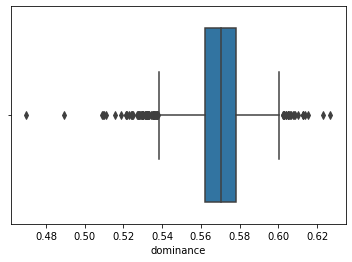

In [ ]:
sns.boxplot(df.dominance)

In [ ]:
df1.valence.round().value_counts()

1.0    4066
0.0       5
Name: valence, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


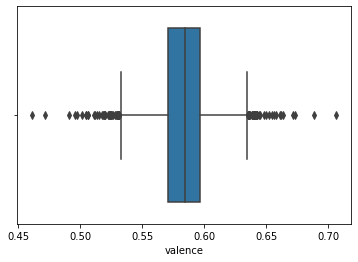

In [ ]:
sns.boxplot(df["valence"])

In [ ]:
df1.arousal.round().value_counts()

0.0    4071
Name: arousal, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


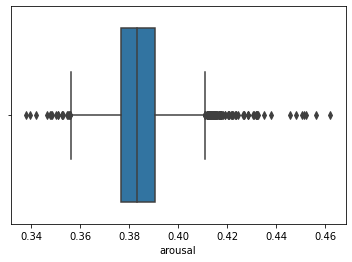

In [ ]:
sns.boxplot(df.arousal)

In [ ]:
df1.dominance.mean()

0.569728363461135

In [ ]:
#converting +1 if dominance value is greater then mean value.
df1['bin_dominance'] = df1['dominance'].apply(lambda x : +1 if x>df1.dominance.mean() else -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#converting +1 if a value is gt mean value.
df1['bin_arousal'] = df1['arousal'].apply(lambda x : +1 if x>df1.arousal.mean() else -1)

#final df for preprocesing and training 
df_aws_rf = df1[['story', 'bin_dominance','bin_arousal']]
#df_aws.to_csv('4000_stories_aws_api.csv',header=True,index=False)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df1.head(1)

,story,valence,arousal,dominance,bin_dominance,bin_arousal
0,"PART I\n\nIf you don't like Christmas stories,...",0.592896,0.397839,0.569567,-1,1


In [ ]:
df1.bin_dominance.value_counts()

 1    2144
-1    1927
Name: bin_dominance, dtype: int64

In [ ]:
#df for aws api
# +1 if story dominate else -1
df_aws = df1[['story', 'bin_dominance']]

#df_aws.to_csv('4000_stories_aws_api.csv',header=True,index=False).

In [ ]:
#for random forest
df_aws_rf.tail(5)

,bin_dominance,bin_arousal,story_cleaned
4066,-1,1,chapter swindle pron nine oclock little town v...
4067,-1,1,chapter passing pron saturday six morning pron...
4068,-1,1,spring particular day five oclock morning sun ...
4069,-1,1,pron coqueville little village plant cleft roc...
4070,-1,1,pron name louis roubien pron seventy year old ...


In [ ]:
#for algo which takes 1d array as target
df_aws.head(1)

,story,bin_dominance
0,"PART I\n\nIf you don't like Christmas stories,...",-1


In [ ]:
#copy file from temporary storage to drive.
!cp 4000_stories_aws_api.csv /content/drive/MyDrive/'Colab Notebooks'/

cp: cannot stat '4000_stories_aws_api.csv': No such file or directory


# Preprocessing

### Tokenization, punctuation, lemmatization, stopwords 

In [ ]:
def text_preprocessing(str_input):  
     #lemmatization
     words=[token.lemma_ for token in nlp(str_input) if not token.is_punct]
 
     # remove symbols
     words = [re.sub(r'[^A-Za-z@]', '', word) for word in words] 
     words = [word for word in words if word!=' ']
     words = [word for word in words if len(word)!=0] 
 
     #remove stopwords     
     words=[word.lower() for word in words if word.lower() not in stopwords.words('english')]
     string = ' '.join(words)     
     return string




In [ ]:
df_aws['story_cleaned'] = df1['story'].apply(text_preprocessing) 

In [ ]:
df_aws_clean = df_aws[['story_cleaned', 'bin_dominance']]
#saving this clean-story file
#df_aws_clean.to_csv('4000_stories_clean_aws_api.csv',header=True,index=False)

In [ ]:
##reading file df_aws_clean df
df_aws_clean_1d = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/4000_stories_clean_aws_api.csv')

In [ ]:
df_aws_clean_1d.head(1)

In [ ]:
#for RF
df_aws_rf['story_cleaned'] = df_aws_clean_1d['story_cleaned']
df_aws_rf.drop(columns=['story'],axis=1,inplace=True)

In [ ]:
df_aws_rf.head(1)

In [ ]:
#df_aws_rf.to_csv('df_aws_rf.csv', index = False, header= True)
!cp df_aws_rf.csv /content/drive/MyDrive/'Colab Notebooks'/

In [ ]:
##reading clean_story file - 2d target var
df_aws_rf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/df_aws_rf.csv')

In [ ]:
df_aws_clean_1d.head(1)

,story_cleaned,bin_dominance
0,part pron pron like christmas story read one p...,-1


## TF*IDF

In [ ]:
#for 1d
#raw
tfidfconverter = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7)
X = tfidfconverter.fit_transform(df_aws_rf.story_cleaned).toarray()

In [ ]:
#final
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
#corpus = df_aws_rf.story_cleaned
vectorizer = CountVectorizer(decode_error="replace")
#vec_train = vectorizer.fit_transform(corpus)

#Save vectorizer.vocabulary_
#pickle.dump(vectorizer.vocabulary_,open("feature.pkl","wb"))

#Load it 
transformer = TfidfTransformer()
loaded_vec = CountVectorizer(decode_error="replace",vocabulary=pickle.load(open("/content/drive/MyDrive/Colab Notebooks/feature.pkl", "rb")))

#on new data point (docs)
#tfidf = transformer.fit_transform(loaded_vec.fit_transform(np.array([doc"])))

In [ ]:
#!cp feature.pkl /content/drive/MyDrive/'Colab Notebooks'/

In [ ]:
#X, Input features
Xn = vec_train.toarray()
#vec_train.shape

In [ ]:
#y Output Variable
y = df_aws_rf[["bin_dominance", 'bin_arousal']]

In [ ]:
Xn.shape

In [ ]:
y

,bin_dominance,bin_arousal
0,-1,1
1,1,-1
2,-1,1
3,-1,1
4,-1,1
...,...,...
4066,-1,1
4067,-1,1
4068,-1,1
4069,-1,1


# Modeling

In [ ]:
#Spliting for rf
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(Xn, y, test_size=0.2, stratify = y, random_state=0)


In [ ]:
params = {'max_depth':[12],
         'n_estimators': [450],
         'criterion': ['entropy'],
         'oob_score':[True],
         'n_jobs':[-1]}

clf1 = RandomForestClassifier()

In [ ]:
model = GridSearchCV(clf1, params, cv=3)
model.fit(X_train, y_train)


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
print(model.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=450,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)


In [ ]:
filename = 'model_rf.sav'
pickle.dump(model, open(filename, 'wb'))
!cp model_rf.sav /content/drive/MyDrive/'Colab Notebooks'/

In [ ]:
#loading model rf : 
model_rf = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/model_rf.sav', 'rb'))


In [ ]:
#the number of correctly predicted rows from the out-of-bag sample
print(model_rf.best_estimator_.oob_score_)

0.7258906633906634


In [ ]:
#score
y_pred = model_rf.predict(X_test)
np.mean(y_pred == y_test)             

bin_dominance    0.763190
bin_arousal      0.704294
dtype: float64

In [ ]:
y_pred = model_rf.predict(X_test)

In [ ]:
#aoc score
predictions = model_rf.predict(X_test)
print('AUC: ', roc_auc_score(y_test, predictions))
# better distinguishing between the positive and negative classes

AUC:  0.7249571826339459


# Modeling for 1d

In [ ]:
X1 = tfidfconverter.fit_transform(df_aws_clean_1d.story_cleaned).toarray()

In [ ]:
y1 = df_aws_clean_1d[["bin_dominance"]]

In [ ]:
#Spliting data
from sklearn.model_selection import train_test_split  
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, stratify = y, random_state=0)


In [ ]:
params = {'max_depth':[1,3,11,12,16],
         'n_estimators': [400,450,500],
         'criterion': ['entropy'],
         'oob_score':[True],
         'n_jobs':[-1]}

rf1 = RandomForestClassifier()

In [ ]:
model = GridSearchCV(rf1, params, cv=3)
model.fit(X1_train, y1_train)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
print(model.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)


In [ ]:
model1 = model.best_estimator_
print(model1.oob_score_)

0.7896191646191646


In [ ]:
#Scores
predictions1 = model1.predict(X1_test)
print('--------------------Final Scores-------------------')
print('AUC: ', roc_auc_score(y1_test, predictions1))
print('Confusion matrix : \n',confusion_matrix(y1_test,predictions1))  
print('classification_report : \n', classification_report(y1_test,predictions1))  
print('accuracy_score : ', accuracy_score(y1_test, predictions1))
 

--------------------Final Scores-------------------
AUC:  0.7795542109013612
Confusion matrix : 
 [[277 109]
 [ 68 361]]
classification_report : 
               precision    recall  f1-score   support

          -1       0.80      0.72      0.76       386
           1       0.77      0.84      0.80       429

    accuracy                           0.78       815
   macro avg       0.79      0.78      0.78       815
weighted avg       0.78      0.78      0.78       815

accuracy_score :  0.7828220858895706


In [ ]:
## Model 2

In [ ]:
#build a machine learning pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

est = Pipeline([('classifier', LogisticRegression(solver='liblinear'))])

#GridSearchCV
parameters = {'classifier__C':np.logspace(-3,3,7), 'classifier__penalty':['l1','l2','25','50']}
gs=GridSearchCV(est,param_grid=parameters)
gs.fit(X1_train, y1_train)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('classifier',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='auto',
                                                           n_jobs=None,
                                                           penalty='l2',
                                                           random_state=None,
                                       

In [ ]:
#Scores
predictions2 = gs.predict(X1_test)
print('--------------------Final Scores-------------------')
print('AUC: ', roc_auc_score(y1_test, predictions2))
print('Confusion matrix : \n',confusion_matrix(y1_test,predictions2))  
print('classification_report : \n', classification_report(y1_test,predictions2))  
print('accuracy_score : ', accuracy_score(y1_test, predictions2))
 

--------------------Final Scores-------------------
AUC:  0.8576578861552955
Confusion matrix : 
 [[322  64]
 [ 51 378]]
classification_report : 
               precision    recall  f1-score   support

          -1       0.86      0.83      0.85       386
           1       0.86      0.88      0.87       429

    accuracy                           0.86       815
   macro avg       0.86      0.86      0.86       815
weighted avg       0.86      0.86      0.86       815

accuracy_score :  0.8588957055214724


# GUI

In [ ]:
story1 ="""There was once a baby show among the Animals in the forest. Jupiter provided the prize. Of course all the proud mammas from far and near brought their babies. But none got there earlier than Mother Monkey. Proudly she presented her baby among the other contestants.

As you can imagine, there was quite a laugh when the Animals saw the ugly flat-nosed, hairless, pop-eyed little creature.

"Laugh if you will," said the Mother Monkey. "Though Jupiter may not give him the prize, I know that he is the prettiest, the sweetest, the dearest darling in the world."

Mother love is blind.""" 


In [ ]:
!pip install -U gradio

  Using cached https://files.pythonhosted.org/packages/ce/65/22ed15392909f9738251fd99d637da7a64ae76c20fdb152e12dd0e6d0cc0/gradio-2.0.9-py3-none-any.whl


In [ ]:
import gradio as gr
#for new data point (docs)
#tfidf = transformer.fit_transform(loaded_vec.fit_transform(np.array([processed_text])))
def generate_text(inp):
    processed_text = text_preprocessing(inp)
    inp_ids = transformer.fit_transform(loaded_vec.fit_transform(np.array([processed_text]))).toarray()
    output1 = model_rf.predict(inp_ids)
    if output1[0,0] == +1 and output1[0,1] == +1:
        return 'Dominating Story: Yes \nArousal Story: Yes \nSentiment : Negative'
    elif (output1[0,0] == -1 and output1[0,1] == -1):
        return 'Dominating Story: No \nArousal Story: No \nSentiment : Positive'
    elif (output1[0,0] == +1 and output1[0,1] == -1):
        return 'Dominating Story: Yes \nArousal Story: No \nSentiment : Negative'
    else :#-1, +1
        return 'Dominating Story: No \nArousal Story: Yes \nSentiment : Positive'

output_text = gr.outputs.Textbox()
gr.Interface(generate_text,"textbox", output_text).launch(debug=True)

AttributeError: ignored

#New sentiment using AWS API

In [ ]:
!pip install boto3

In [ ]:
###

In [ ]:
import os
import boto3
import csv
with open('/content/drive/MyDrive/Colab Notebooks/pravesh_nlp__aws_new_user_credentials.csv', 'r') as input:
    next(input) #goto second line
    reader = csv.reader(input)
    for line in reader:
        access_key_id = line[2] #see file .csv
        secret_access_key = line[3]
client = boto3.client ('comprehend', aws_access_key_id = access_key_id, aws_secret_access_key = secret_access_key, region_name='us-west-2')

In [ ]:
response = client.detect_sentiment(Text=text, LanguageCode='en')
        

In [ ]:
response

{'ResponseMetadata': {'HTTPHeaders': {'content-length': '161',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 29 Jun 2021 11:14:10 GMT',
   'x-amzn-requestid': 'a07a0c72-f63d-40a9-835a-c223e7c300de'},
  'HTTPStatusCode': 200,
  'RequestId': 'a07a0c72-f63d-40a9-835a-c223e7c300de',
  'RetryAttempts': 0},
 'Sentiment': 'MIXED',
 'SentimentScore': {'Mixed': 0.8945317268371582,
  'Negative': 0.005873120855540037,
  'Neutral': 0.005875947419553995,
  'Positive': 0.09371914714574814}}

In [ ]:
response['Sentiment']

In [ ]:
str(response['SentimentScore'])

"{'Positive': 0.09371914714574814, 'Negative': 0.005873120855540037, 'Neutral': 0.005875947419553995, 'Mixed': 0.8945317268371582}"

In [ ]:
# UI interface for AWS 

In [ ]:
#final
import gradio as gr
def generate_text(inp):
    response = client.detect_sentiment(Text = inp, LanguageCode = 'en')

    return 'Sentiment For Input Text: '+ response['Sentiment']+ '\nScores:\nMixed : '+str(round(response['SentimentScore']['Mixed'],4))+'\nNegative: '+str(round(response['SentimentScore']['Negative'],4))+'\nNeutral : '+str(round(response['SentimentScore']['Neutral'],4)) +'\nPositive : '+str(round(response['SentimentScore']['Positive'],4))

output_text = gr.outputs.Textbox()
gr.Interface(generate_text,"textbox", output_text).launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://57819.gradio.app
Interface loading below...


[2021-06-29 11:34:11,891] ERROR in app: Exception on /api/predict/ [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.7/dist-packages/flask_cors/extension.py", line 165, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)))
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.7/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1936, in dispatch_

KeyboardInterrupt: ignored

In [ ]:
response['SentimentScore']['Mixed'],4)

0.8945

# adding emotions 

In [ ]:
!pip install text2emotion

     |████████████████████████████████| 61kB 5.4MB/s 
     |████████████████████████████████| 133kB 21.2MB/s 


In [ ]:
import text2emotion as te

In [ ]:
ss = te.get_emotion('i love it man ')

In [ ]:
#gui
#final
import gradio as gr
def generate_text(inp):
    response = client.detect_sentiment(Text = inp, LanguageCode = 'en')
    e_res = te.get_emotion(inp)
    return 'Sentiment For Input Text: '+ response['Sentiment']+ '\nScores:\nMixed : '+str(round(response['SentimentScore']['Mixed'],4))+'\nNegative: '+str(round(response['SentimentScore']['Negative'],4))+'\nNeutral : '+str(round(response['SentimentScore']['Neutral'],4)) +'\nPositive : '+str(round(response['SentimentScore']['Positive'],4)) + '\n\nEmotion Scores:\n' + 'Angry : '+str(e_res['Angry']) +'\nFear : '+str(e_res['Fear'])+ '\nHappy : '+str(e_res['Happy']) + '\nSad : '+str(e_res['Sad']) + '\nSurprise : '+str(e_res['Surprise'])

output_text = gr.outputs.Textbox()
gr.Interface(generate_text,"textbox", output_text).launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://29264.gradio.app
Interface loading below...


In [ ]:
ss

{'Angry': 0.0, 'Fear': 0.0, 'Happy': 1.0, 'Sad': 0.0, 'Surprise': 0.0}